# Preparing Time Series from Wide-Form Data Core

## Imports/Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
# set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
## Customization Options
# plt.style.use(['fivethirtyeight'])#'seaborn-talk'])#,
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)

In [3]:
df = pd.read_csv('Data/City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


## Functions

In [4]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

In [5]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

## Part 1

- Filter the 4 largest cities into a new dataframe.

    - Tip: the "SizeRank" column has already ranked the cities by size. The larger the city, the smaller the rank value.
     - Therefore the 4 largest cities would have rank values of [0,1,2,3]
   
- Melt the data to long-form and prepare it for time series analysis.
     - Convert the melted dates into datetime datatype.
     - Make the datetime column the index.

- Resample the dataframe as monthly frequency, grouped by City.
     

In [6]:
# Filter the 4 largest cities into a new dataframe
largest_cities = df[df['SizeRank'] <= 3]

In [7]:
largest_cities

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [8]:
# Melt the data to long-form and prepare it for time series analysis.
melted_df = pd.melt(largest_cities.drop(columns=['StateName','RegionType','RegionID']),
                 id_vars=['SizeRank', 'RegionName', 'State', 'Metro', 'CountyName'],
                value_name='Price',var_name="Date")
melted_df



,SizeRank,RegionName,State,Metro,CountyName,Date,Price
0,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...
1087,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [9]:
# Convert the melted dates into datetime datatype.
melted_df['Date'] = pd.to_datetime(melted_df['Date'])
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SizeRank    1092 non-null   int64         
 1   RegionName  1092 non-null   object        
 2   State       1092 non-null   object        
 3   Metro       1092 non-null   object        
 4   CountyName  1092 non-null   object        
 5   Date        1092 non-null   datetime64[ns]
 6   Price       1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 59.8+ KB


In [10]:
# Make the datetime column the index
melted_df = melted_df.set_index("Date")
melted_df

,SizeRank,RegionName,State,Metro,CountyName,Price
Date,,,,,,
2000-01-31,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
...,...,...,...,...,...,...
2022-08-31,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,315587.0
2022-09-30,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,781622.0
2022-09-30,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,966595.0


In [11]:
# Resample the dataframe as monthly frequency, grouped by City
df_ts = melted_df.groupby('RegionName').resample("MS").mean()
df_ts

C:\Users\Justice\AppData\Local\Temp\ipykernel_73340\2444456701.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ts = melted_df.groupby('RegionName').resample("MS").mean()


SizeRank     Price
RegionName Date                          
Chicago    2000-01-01       3.0  166139.0
           2000-02-01       3.0  166536.0
           2000-03-01       3.0  167368.0
           2000-04-01       3.0  168826.0
           2000-05-01       3.0  170499.0
...                         ...       ...
New York   2022-05-01       0.0  768797.0
           2022-06-01       0.0  773944.0
           2022-07-01       0.0  777692.0
           2022-08-01       0.0  779960.0
           2022-09-01       0.0  781622.0

[1092 rows x 2 columns]

In [12]:
df_ts.head().index

MultiIndex([('Chicago', '2000-01-01'),
            ('Chicago', '2000-02-01'),
            ('Chicago', '2000-03-01'),
            ('Chicago', '2000-04-01'),
            ('Chicago', '2000-05-01')],
           names=['RegionName', 'Date'])

In [13]:
plot_df = df_ts.drop(columns=['SizeRank'])
plot_df

Price
RegionName Date                
Chicago    2000-01-01  166139.0
           2000-02-01  166536.0
           2000-03-01  167368.0
           2000-04-01  168826.0
           2000-05-01  170499.0
...                         ...
New York   2022-05-01  768797.0
           2022-06-01  773944.0
           2022-07-01  777692.0
           2022-08-01  779960.0
           2022-09-01  781622.0

[1092 rows x 1 columns]

## Part 2
- Once you've prepared the dataframe with the time series data for the 4 largest cities:

    - Plot the home values for all 4 cities.
        - Make sure to add a title and axis labels.
        - Reformat the y-axis ticks to use thousands of dollars with a "K" at the end. (e.g. "200K, 400K, etc")
            
    - Answer the following 2 questions using pandas:
        - 1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?
            
        - 2) How much did the home values change from November 2008 to December 2008 (in dollars)?
            

In [14]:
# level 0 is Country/Region
plot_df.index.get_level_values(0)

Index(['Chicago', 'Chicago', 'Chicago', 'Chicago', 'Chicago', 'Chicago',
       'Chicago', 'Chicago', 'Chicago', 'Chicago',
       ...
       'New York', 'New York', 'New York', 'New York', 'New York', 'New York',
       'New York', 'New York', 'New York', 'New York'],
      dtype='object', name='RegionName', length=1092)

In [15]:
unstacked_plot = plot_df.unstack(level=0)

In [16]:
import matplotlib.ticker as mticker

def format_ticks(x, pos):
    return f"${x/1000:.0f}K"

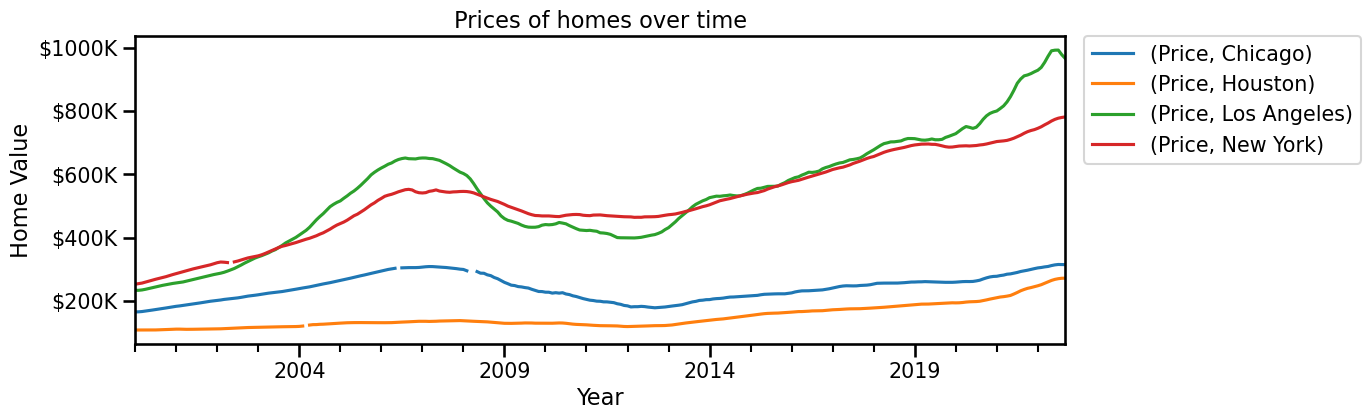

In [17]:
ax = unstacked_plot.plot()
ax.set_title('Prices of homes over time')
ax.set_ylabel('Home Value')
ax.set_xlabel('Year')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_ticks))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### Which City had the highest Typical Home Value at the end of 2008? Which had the least?

- Looking at the plot above, at the end of 2008 the city with the highest typical home value was New York. The city with the least was Houston.

### How much did the home values change from November 2008 to December 2008 (in dollars)?



In [18]:
dates = df_ts.loc['2008-11-01':'2008-12-31']
dates

,,SizeRank,Price
RegionName,Date,,


In [20]:
ts_diff = unstacked_plot.diff()
ts_diff

Price                             
RegionName Chicago Houston Los Angeles New York
Date                                           
2000-01-01     NaN     NaN         NaN      NaN
2000-02-01   397.0    11.0       220.0   1827.0
2000-03-01   832.0  -201.0      1112.0   1690.0
2000-04-01  1458.0     3.0      2076.0   3103.0
2000-05-01  1673.0   -47.0      2524.0   2894.0
...            ...     ...         ...      ...
2022-05-01  2838.0  4457.0     17223.0   6476.0
2022-06-01  2176.0  3343.0      1946.0   5147.0
2022-07-01  1247.0  2158.0       293.0   3748.0
2022-08-01  -323.0  1341.0    -14434.0   2268.0
2022-09-01  -158.0   239.0    -11601.0   1662.0

[273 rows x 4 columns]

In [22]:
dates = ts_diff.loc['2008-12-01']
dates

       RegionName 
Price  Chicago        -5753.0
       Houston         -964.0
       Los Angeles   -12611.0
       New York       -4458.0
Name: 2008-12-01 00:00:00, dtype: float64

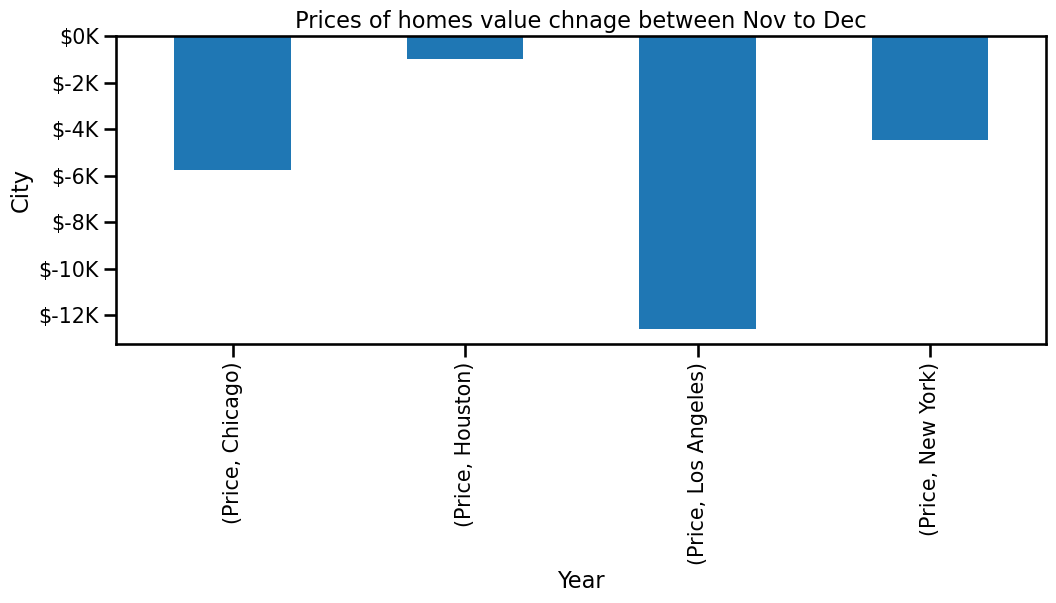

In [27]:
ax = dates.plot(kind='bar')
ax.set_title('Prices of homes value chnage between Nov to Dec')
ax.set_ylabel('City')
ax.set_xlabel('Year')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_ticks))